In [10]:
import json
import pandas as pd
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
pd.set_option("display.max_colwidth",None)
import os

In [4]:
with open("Desktop/open-data-main/data/kpi_definitions.json", "r", encoding="utf-8") as f:
    kpi_defs = json.load(f)

kpi_names = [kpi["name"] for kpi in kpi_defs]

print(f"Numero totale di KPI: {len(kpi_names)}")
for name in kpi_names:
    print(name)

Numero totale di KPI: 103
BYPASSED_OPPONENTS
BYPASSED_OPPONENTS_NUMBER
BYPASSED_DEFENDERS
BYPASSED_OPPONENTS_WO_VERIFICATION
BYPASSED_DEFENDERS_WO_VERIFICATION
BYPASSED_OPPONENTS_BY_ACTION_SECOND_BALL
BYPASSED_OPPONENTS_RECEIVING
BYPASSED_OPPONENTS_RECEIVING_NUMBER
BYPASSED_DEFENDERS_RECEIVING
BYPASSED_OPPONENTS_RECEIVING_DUETO_VERIFICATION
NEUTRAL_PLAY_NUMBER
REVERSE_PLAY_ADDED_OPPONENTS
REVERSE_PLAY_NUMBER
BALL_LOSS_ADDED_OPPONENTS
BALL_LOSS_REMOVED_TEAMMATES
BALL_LOSS_NUMBER
BALL_WIN_ADDED_TEAMMATES
BALL_WIN_REMOVED_OPPONENTS
BALL_WIN_REMOVED_OPPONENTS_DEFENDERS
BALL_WIN_NUMBER
GOALS
BYPASSED_OPPONENTS_MIDFIELD
BALL_LOSS_ADDED_OPPONENTS_DEFENDERS
BALL_WIN_ADDED_TEAMMATES_DEFENDERS
REVERSE_PLAY_ADDED_OPPONENTS_DEFENDERS
OWNGOALS
RED_CARD
CRITICAL_BALL_LOSS_NUMBER
BALL_LOSS_REMOVED_TEAMMATES_DEFENDERS
BYPASSED_DEFENDERS_BY_ACTION_SECOND_BALL
ASSISTS
SHOT_XG
PACKING_XG
SUCCESSFUL_PASSES
UNSUCCESSFUL_PASSES
OFFENSIVE_TOUCHES
DEFENSIVE_TOUCHES
WON_GROUND_DUELS
LOST_GROUND_DUELS
WON_AERIA

In [13]:
# --- PATH ---
BASE_DIR = os.path.expanduser("~/Desktop/open-data-main/data")

EVENTS_DIR = os.path.join(BASE_DIR, "events_kpis")
PLAYER_DIR = os.path.join(BASE_DIR, "player_kpis")
KPI_DEFS_PATH = os.path.join(BASE_DIR, "kpi_definitions.json")

# --- 1) Carica definizioni KPI: id -> (name, meaning) ---
with open(KPI_DEFS_PATH, "r", encoding="utf-8") as f:
    kpi_defs = json.load(f)

# Robust: alcuni KPI hanno "details": null
kpi_map = {}
for k in kpi_defs:
    kpi_id = int(k["id"])
    name = k.get("name")

    details = k.get("details")
    meaning = details.get("meaning") if isinstance(details, dict) else None

    kpi_map[kpi_id] = {
        "kpi_name": name,
        "meaning": meaning
    }

# --- Helpers: estrai kpiId da JSON ---
def kpi_ids_from_events_file(path: str) -> set:
    """events_kpis files are typically a list of objects with 'kpiId'."""
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    ids = set()
    if isinstance(data, list):
        for x in data:
            if isinstance(x, dict) and "kpiId" in x and x["kpiId"] is not None:
                try:
                    ids.add(int(x["kpiId"]))
                except Exception:
                    pass
    return ids

def kpi_ids_from_nested_json(path: str) -> set:
    """player_kpis files can be nested; collect all 'kpiId' keys recursively."""
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    ids = set()

    def walk(obj):
        if isinstance(obj, dict):
            if "kpiId" in obj and obj["kpiId"] is not None:
                try:
                    ids.add(int(obj["kpiId"]))
                except Exception:
                    pass
            for v in obj.values():
                walk(v)
        elif isinstance(obj, list):
            for v in obj:
                walk(v)

    walk(data)
    return ids

def list_json_files(folder: str) -> list:
    """List all .json files in a folder (no glob)."""
    files = []
    for name in os.listdir(folder):
        if name.lower().endswith(".json"):
            files.append(os.path.join(folder, name))
    return sorted(files)

# --- 2) Itera su tutti i JSON in events_kpis/ ---
event_ids = set()
for fp in list_json_files(EVENTS_DIR):
    event_ids |= kpi_ids_from_events_file(fp)

# --- 3) Itera su tutti i JSON in player_kpis/ ---
player_ids = set()
for fp in list_json_files(PLAYER_DIR):
    player_ids |= kpi_ids_from_nested_json(fp)

# --- 4) Unique totale ---
all_ids = sorted(event_ids | player_ids)

# --- 5) DataFrame finale + source flags ---
rows = []
for kpi_id in all_ids:
    meta = kpi_map.get(kpi_id, {})
    rows.append({
        "kpiId": kpi_id,
        "kpi_name": meta.get("kpi_name"),
        "meaning": meta.get("meaning"),
        "in_events_kpis": kpi_id in event_ids,
        "in_player_kpis": kpi_id in player_ids,
    })

df_kpis = pd.DataFrame(rows)

print(f"events_kpis unique KPI IDs: {len(event_ids)}")
print(f"player_kpis unique KPI IDs: {len(player_ids)}")
print(f"TOTAL unique KPI IDs: {len(all_ids)}")

events_kpis unique KPI IDs: 94
player_kpis unique KPI IDs: 101
TOTAL unique KPI IDs: 101


In [14]:
df_kpis

,kpiId,kpi_name,meaning,in_events_kpis,in_player_kpis
0,0,BYPASSED_OPPONENTS,"Ball Progression, offensive game-play, verticality. The line breaking pass of a centre-back through two opposing strikers to the free midfielder bypasses 2 opponents.",True,True
1,1,BYPASSED_OPPONENTS_NUMBER,Number of successful offensive actions by a player.,True,True
2,2,BYPASSED_DEFENDERS,"Initiating dangerous attacks with the ball, play in advanced areas, penetrating the opposition defence. A deadly pass from a midfield to a the striker, who is then free in front of the goal, bypasses all 5 defenders.",True,True
3,3,BYPASSED_OPPONENTS_WO_VERIFICATION,"Bypassed opponents purely from the point of view of the passer without considering the follow-up action of their teammate. In this way, the performance of the passer can be considered independently of the performance of the pass receiver - e.g. regardless of whether the teammate is able to hold the ball up or lay off the ball.",True,True
4,4,BYPASSED_DEFENDERS_WO_VERIFICATION,"Bypassed defenders purely from the point of view of the passer without considering the follow-up action of their teammate. In this way, the performance of the passer can be considered independently of the performance of the pass receiver - e.g. regardless of whether the teammate is able to hold the ball up or lay off the ball.",True,True
5,6,BYPASSED_OPPONENTS_BY_ACTION_SECOND_BALL,None,True,True
6,7,BYPASSED_OPPONENTS_RECEIVING,"Good spatial awareness, showing for the ball in between the lines, creating one-twos, good movement without the ball, long balls. Every action with bypassed opponents from the point of view of the pass receiver.",True,True
7,8,BYPASSED_OPPONENTS_RECEIVING_NUMBER,Number of actions in which a player is found as a receiver.,True,True
8,9,BYPASSED_DEFENDERS_RECEIVING,"Deep runs, showing up within or behind the opposition defence, creating a goalscoring opportunity through running & movement, getting into dangerous areas. A deadly pass from the point of view of the pass receiver, who made the pass possible by an intelligent run.",True,True
9,10,BYPASSED_OPPONENTS_RECEIVING_DUETO_VERIFICATION,"If a player is played the ball under high pressure, the bypassed opponents are not fully counted as a contact until the ball is completely under control. This value here refers exclusively to the verification of bypassed opponents by the pass receiver (by holding it up or laying it off). This way, the performance of the pass receiver is appreciated, E.g. the ability to hold up balls under pressure. The bypassed opponents are then fully valued, so that they verifies the pass of his teammate.",True,True


In [5]:
KPI_TO_USE = [
    "PXT_PASS",
    "PXT_ATTACK",
    "PXT_DEFEND",
    "DISTANCE_TO_GOAL_COVERED_FDR",
    "DISTANCE_TO_GOAL_COVERED_DRIBBLE",
    "SUCCESSFUL_PASSES",
    "NEUTRAL_PASSES",
    "EXPECTED_GOAL_ASSISTS",
    "EXPECTED_PASSES",
    "DEF_PXT_ATTACK",
    "DEF_PXT_DEFEND",
    "NUMBER_OF_PRESSES",
    "SECOND_BALL_WIN",
    "BALL_LOSS_NUMBER",
    "CRITICAL_BALL_LOSS_NUMBER",
    "UNSUCCESSFUL_PASSES"
]

In [7]:
# Filtra solo i KPI che ci servono
rows = []
for kpi in kpi_defs:
    name = kpi.get("name")
    if name in KPI_TO_USE:
        rows.append({
            "kpi_name": name,
            "meaning": kpi.get("details", {}).get("meaning")
        })

# Crea DataFrame
df_kpis_used = pd.DataFrame(rows)

# Ordina come nella lista KPI_TO_USE
df_kpis_used["kpi_name"] = pd.Categorical(
    df_kpis_used["kpi_name"],
    categories=KPI_TO_USE,
    ordered=True
)
df_kpis_used = df_kpis_used.sort_values("kpi_name").reset_index(drop=True)

In [8]:
df_kpis_used

,kpi_name,meaning
0,PXT_PASS,Changing your goal threat through passing.
1,PXT_ATTACK,Evaluates a player's impact on goal probability while their team is attacking.
2,PXT_DEFEND,Evaluates a player's impact on goal probability while their team is defending.
3,DISTANCE_TO_GOAL_COVERED_FDR,Distance to goal covered by receiving a pass in a deep run.
4,DISTANCE_TO_GOAL_COVERED_DRIBBLE,Distance to goal covered by progressive dribbles.
5,SUCCESSFUL_PASSES,Pass that reaches the teammate.
6,NEUTRAL_PASSES,Pass that ends in a high pressure situation.
7,EXPECTED_GOAL_ASSISTS,"This KPI provides a stabilized, expectation-based view of creative output, reducing the variance inherent in raw assists. It reflects how many assists a player would normally be expected to achieve given the quality of their deliveries, independent of whether teammates actually finished the chances. A higher value signals that the player consistently generates passes/set pieces with strong goal-assist potential, making it a fairer indicator of underlying creative contribution than realized assists alone."
8,EXPECTED_PASSES,"Expected passes provide a statistical benchmark for assessing passing performance. By comparing expected passes with a player’s actual successful passes, we can measure whether the player is completing more or fewer passes than the model predicts. To do this, two derived scores are useful: Pass Completion Over Expected and Pass Accuracy Over Expected. These scores capture whether a player is performing above, in line with, or below the expected baseline, and help highlight technical passing skill, decision-making, and ability under pressure. Example: If a player attempts 10 passes and completes 8, while the model predicts 7.5 expected completions, then: Pass Completion Over Expected = (8 – 7.5) / 7.5 = +6.7% and Pass Accuracy Over Expected = (8 – 7.5) / 10 = +5%."
9,DEF_PXT_ATTACK,Evaluates a player's impact on the probability of conceding a goal while their team is attacking.


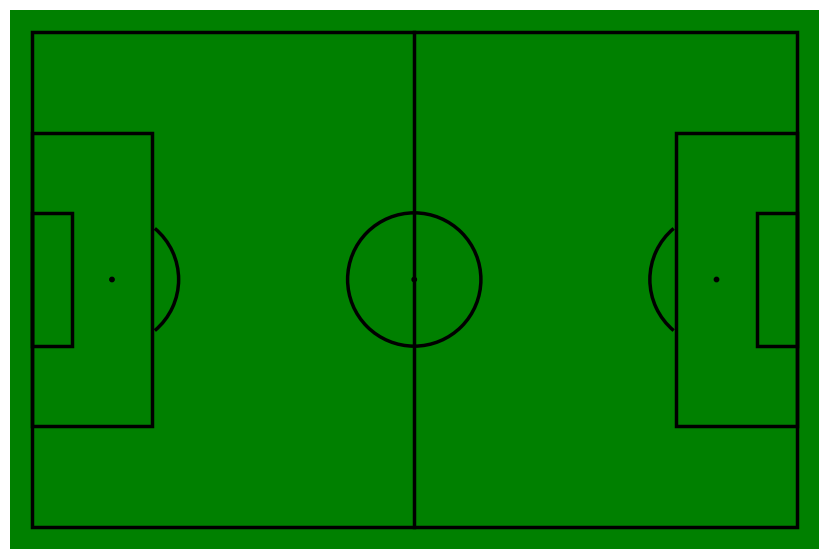

<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Arc

def draw_pitch(
    ax=None,
    length=105, width=68,        # meters (standard-ish)
    line_color="black",
    lw=2.5,
    background="green",        # beige like your example
    show=True
):
    """
    Draw a soccer pitch (no network), in a style similar to your screenshot.
    Coordinates: (0,0) bottom-left, (length,width) top-right.
    """

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 7))
    else:
        fig = ax.figure

    # Background
    ax.set_facecolor(background)

    # Outer boundary
    ax.add_patch(Rectangle((0, 0), length, width, fill=False,
                           edgecolor=line_color, linewidth=lw))

    # Halfway line
    ax.plot([length/2, length/2], [0, width], color=line_color, lw=lw)

    # Centre circle + spot
    centre = (length/2, width/2)
    ax.add_patch(Circle(centre, 9.15, fill=False, edgecolor=line_color, linewidth=lw))
    ax.add_patch(Circle(centre, 0.3, color=line_color))

    # Penalty areas
    # Left
    ax.add_patch(Rectangle((0, (width/2) - 20.16), 16.5, 40.32, fill=False,
                           edgecolor=line_color, linewidth=lw))
    # Right
    ax.add_patch(Rectangle((length - 16.5, (width/2) - 20.16), 16.5, 40.32, fill=False,
                           edgecolor=line_color, linewidth=lw))

    # 6-yard boxes
    # Left
    ax.add_patch(Rectangle((0, (width/2) - 9.16), 5.5, 18.32, fill=False,
                           edgecolor=line_color, linewidth=lw))
    # Right
    ax.add_patch(Rectangle((length - 5.5, (width/2) - 9.16), 5.5, 18.32, fill=False,
                           edgecolor=line_color, linewidth=lw))

    # Penalty spots
    ax.add_patch(Circle((11, width/2), 0.3, color=line_color))
    ax.add_patch(Circle((length - 11, width/2), 0.3, color=line_color))

    # Penalty arcs ("D")
    # Left arc: center at penalty spot, show only outside the box
    ax.add_patch(Arc((11, width/2), height=18.3, width=18.3,
                     angle=0, theta1=310, theta2=50,
                     color=line_color, lw=lw))
    # Right arc
    ax.add_patch(Arc((length - 11, width/2), height=18.3, width=18.3,
                     angle=0, theta1=130, theta2=230,
                     color=line_color, lw=lw))

    # Remove ticks/frames like the example
    ax.set_xlim(-3, length + 3)
    ax.set_ylim(-3, width + 3)
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    if show:
        plt.show()

    return fig, ax


# Example usage
fig, ax = draw_pitch()
ax.set_title("FC Dallas, 3421 formation", fontsize=22)  # just to mimic the screenshot
ax.text(6, 3, "Minutes: 0 - 69", fontsize=14, family="monospace")  # optional label
plt.savefig("pitch.png", dpi=300, bbox_inches="tight")
plt.show()

In [5]:
import json

# Carica il file JSON
with open("data/players/players_743.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Estrai i nomi dei giocatori con currentSquadId = 33
players_33 = [
    p["commonname"]
    for p in data
    if p.get("currentSquadId") == 33
]

# Stampa il risultato
print(len(players_33))

23


In [6]:
players_33

['Joshua Kimmich',
 'Thomas Müller',
 'Harry Kane',
 'Kingsley Coman',
 'Raphaël Guerreiro',
 'Jonathan Tah',
 'Manuel Neuer',
 'Leon Goretzka',
 'Sven Ulreich',
 'Serge Gnabry',
 'Konrad Laimer',
 'Dayot Upamecano',
 'Josip Stanisic',
 'Daniel Peretz',
 'Alphonso Davies',
 'Sacha Boey',
 'Hiroki Ito',
 'Min-jae Kim',
 'Jamal Musiala',
 'Bryan Zaragoza',
 'Lovro Zvonarek',
 'Tom Bischof',
 'Aleksandar Pavlovic']

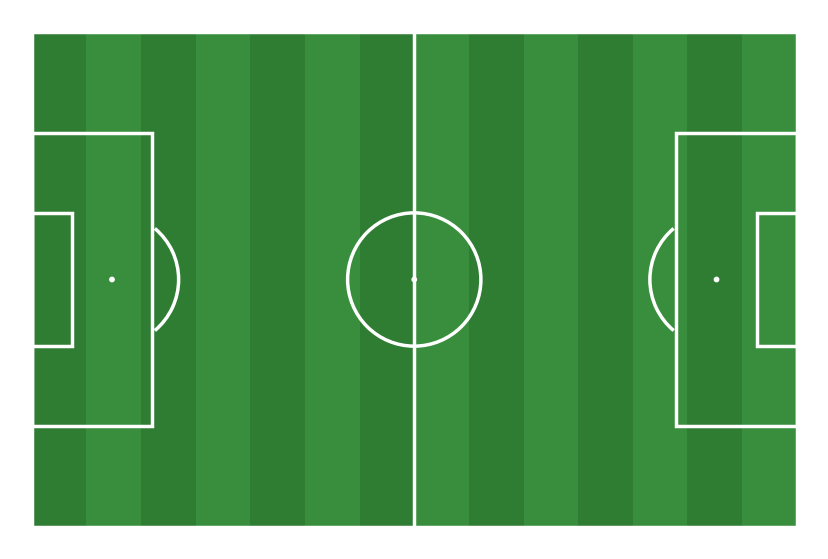

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Arc


def draw_pitch(
    ax=None,
    length=105, width=68,        # meters
    line_color="white",         # LINEE BIANCHE
    lw=2.5,
    grass_colors=("#2e7d32", "#388e3c"),  # verde scuro / verde chiaro
    n_stripes=14,               # numero di strisce
    show=True
):
    """
    Draw a soccer pitch with striped grass and white lines.
    """

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 7))
    else:
        fig = ax.figure


    # =============================
    # DRAW GRASS STRIPES (VERTICAL)
    # =============================
    stripe_width = length / n_stripes

    for i in range(n_stripes):
        color = grass_colors[i % 2]

        ax.add_patch(
            Rectangle(
                (i * stripe_width, 0),   # x cambia, y = 0
                stripe_width,            # larghezza striscia
                width,                   # tutta l'altezza
                facecolor=color,
                edgecolor="none",
                zorder=0
            )
        )

    # =============================
    # OUTER BOUNDARY
    # =============================
    ax.add_patch(
        Rectangle((0, 0), length, width,
                  fill=False,
                  edgecolor=line_color,
                  linewidth=lw,
                  zorder=5)
    )


    # =============================
    # HALFWAY LINE
    # =============================
    ax.plot(
        [length/2, length/2], [0, width],
        color=line_color, lw=lw, zorder=5
    )


    # =============================
    # CENTER CIRCLE + SPOT
    # =============================
    centre = (length/2, width/2)

    ax.add_patch(
        Circle(centre, 9.15,
               fill=False,
               edgecolor=line_color,
               linewidth=lw,
               zorder=5)
    )

    ax.add_patch(
        Circle(centre, 0.3,
               color=line_color,
               zorder=5)
    )


    # =============================
    # PENALTY AREAS
    # =============================

    # Left
    ax.add_patch(
        Rectangle((0, (width/2)-20.16),
                  16.5, 40.32,
                  fill=False,
                  edgecolor=line_color,
                  linewidth=lw,
                  zorder=5)
    )

    # Right
    ax.add_patch(
        Rectangle((length-16.5, (width/2)-20.16),
                  16.5, 40.32,
                  fill=False,
                  edgecolor=line_color,
                  linewidth=lw,
                  zorder=5)
    )


    # =============================
    # 6-YARD BOXES
    # =============================

    # Left
    ax.add_patch(
        Rectangle((0, (width/2)-9.16),
                  5.5, 18.32,
                  fill=False,
                  edgecolor=line_color,
                  linewidth=lw,
                  zorder=5)
    )

    # Right
    ax.add_patch(
        Rectangle((length-5.5, (width/2)-9.16),
                  5.5, 18.32,
                  fill=False,
                  edgecolor=line_color,
                  linewidth=lw,
                  zorder=5)
    )


    # =============================
    # PENALTY SPOTS
    # =============================
    ax.add_patch(Circle((11, width/2), 0.3, color=line_color, zorder=5))
    ax.add_patch(Circle((length-11, width/2), 0.3, color=line_color, zorder=5))


    # =============================
    # PENALTY ARCS
    # =============================

    ax.add_patch(
        Arc((11, width/2), 18.3, 18.3,
            angle=0, theta1=310, theta2=50,
            color=line_color, lw=lw, zorder=5)
    )

    ax.add_patch(
        Arc((length-11, width/2), 18.3, 18.3,
            angle=0, theta1=130, theta2=230,
            color=line_color, lw=lw, zorder=5)
    )


    # =============================
    # AXIS SETTINGS
    # =============================

    ax.set_xlim(-3, length+3)
    ax.set_ylim(-3, width+3)
    ax.set_aspect("equal")

    ax.set_xticks([])
    ax.set_yticks([])

    for spine in ax.spines.values():
        spine.set_visible(False)


    if show:
        plt.show()

    return fig, ax


# =============================
# EXAMPLE
# =============================
fig, ax = draw_pitch(show=False)

#ax.set_title("FC Dallas, 3421 formation", fontsize=22)
#ax.text(6, 3, "Minutes: 0 - 69", fontsize=14, family="monospace")

plt.savefig("pitch.png", dpi=300, bbox_inches="tight")
plt.show()